In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import netCDF4 as nc
import xarray as xr
import numpy as np
import netCDF4 as nc
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.basemap import shiftgrid
import matplotlib.pyplot as plt
import pandas as pd
from dtw import *
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import SGDRegressor
from netuno import SSTHelper, SubserieDTW
from sklearn.multioutput import MultiOutputRegressor

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [197]:
f_inv = lambda x: x + 180
f = lambda x: ((x+180) % 360) - 180

In [198]:
fp = '../dados/sst.mnmean.nc'
ds = SSTHelper.load_dataset(fp)
df = SSTHelper.load_dataframe(ds)

In [199]:
df['lat'] -= 0.5
df['lon'] -= 0.5

## Obtendo 5 pontos no mar
* Um ponto na região do ENSO;
 -> lat = 20°, lon = -132° (https://www.google.com.br/maps/place/20%C2%B000'00.0%22N+132%C2%B000'00.0%22W/@22.1775213,-151.1364928,3.87z/data=!4m4!3m3!8m2!3d20!4d-132?entry=ttu)

* Um ponto na costa do Chile (Corrente de Humboldt);
 -> lat = -22°, lon = -72° (https://www.google.com.br/maps/place/22%C2%B000'00.0%22S+72%C2%B000'00.0%22W/@-21.7898533,-87.474343,4.04z/data=!4m4!3m3!8m2!3d-22!4d-72?entry=ttu)

* Um ponto no meio do Mediterrâneo;
 -> lat = 36°, lon = 18° (https://www.google.com.br/maps/place/36%C2%B000'00.0%22N+18%C2%B000'00.0%22E/@36.0000043,17.9974251,17z/data=!3m1!4b1!4m4!3m3!8m2!3d36!4d18?entry=ttu)

* Um ponto no meio do Atlântico;
 -> lat = 0°, lon = -22° (https://www.google.com.br/maps/place/0%C2%B000'00.0%22N+22%C2%B000'00.0%22W/@-11.0144452,-50.6148726,3z/data=!4m3!3m2!8m1!4d-22?entry=ttu)

* Um ponto no extremo Índico (ponto de maior latitude, temperaturas mais baixas)
 -> lat = -56°, lon = 80° (https://www.google.com.br/maps/place/56%C2%B000'00.0%22S+80%C2%B000'00.0%22E/@-36.027701,54.6888129,3z/data=!4m4!3m3!8m2!3d-56!4d80?entry=ttu)

In [99]:
split_date = '2010-12-01'

chil = SubserieDTW(df, -22, -72, split_date, forecast_horizon=12)
medi = SubserieDTW(df, 36, 18, split_date, forecast_horizon=12)
atla = SubserieDTW(df, 0, -2, split_date, forecast_horizon=12)
enso = SubserieDTW(df, 20, -132, split_date, forecast_horizon=12)

indi = SubserieDTW(df, -56, 80, split_date, forecast_horizon=12)

### DS (Dynamic time warping + Support vector regression)
Implementando a técnica de forecasting apresentada pelo artigo [Improved Particle Swarm Optimization for Sea Surface Temperature Prediction](https://www.mdpi.com/1996-1073/13/6/1369) nomeada DS. Nesse algoritmo, para prever as próximas $x$ observações pegamos a janela referente as últimas observações que possuímos e procuramos subséries anteriores de mesmo tamanho utilizando DTW. Então, utilizamos as subséries mais próximas e as respectivas próximas $x$ observações encontradas para treinar um SVR.

### Queremos predizer a série em '?'
![img1](../resources/img1.png)
### Pegamos a janela mais próxima de tamanho $n$ e comparamos com a série em azul
![img2](../resources/img2.png)
### Pegamos as subséries mais próximas (x) e as observações seguintes (y)
![img3](../resources/img3.png)
### Treinamos um modelo regressor (SVR) para predizer os próximos valores utilizando x,y
![img4](../resources/img4.png)

In [7]:
from netuno import DSPipeline

In [8]:
df

,lat,lon,time,nbnds,sst,time_bnds
0,89.0,0.0,1981-12-01,0,-1.79,1981-12-01
2,89.0,0.0,1982-01-01,0,-1.79,1982-01-01
4,89.0,0.0,1982-02-01,0,-1.79,1982-02-01
6,89.0,0.0,1982-03-01,0,-1.79,1982-03-01
8,89.0,0.0,1982-04-01,0,-1.79,1982-04-01
...,...,...,...,...,...,...
64022390,-90.0,-1.0,2022-09-01,0,-1.79,2022-09-01
64022392,-90.0,-1.0,2022-10-01,0,-1.79,2022-10-01
64022394,-90.0,-1.0,2022-11-01,0,-1.79,2022-11-01
64022396,-90.0,-1.0,2022-12-01,0,-1.79,2022-12-01


### Indian Ocean

In [9]:
indi_pipeline = DSPipeline(df, -56, 80, split_date, forecast_horizon=12)
print("RMSE: ", indi_pipeline.make_pipeline(series_sample_ratio=1, top_subseries_ratio=0.3))
print("MAPE: ", indi_pipeline.evaluate_mape())
indi_pipeline.plot_predict('ÍNDICO - SVR', 'SVR')

RMSE:  [[ 0.60460551  1.53007437  2.09960359 ... -0.45910718 -0.66192353
  -0.18431916]
 [ 1.52971884  2.09984477  2.02848101 ... -0.76265677 -0.29347729
   0.69329528]
 [ 2.14676007  2.01549118  1.55962444 ... -0.2720655   0.66368483
   1.73323373]
 ...
 [ 0.94671494  1.64082519  1.99790366 ... -0.89036028 -0.68130223
   0.08790338]
 [ 1.54824315  1.91898292  1.68481951 ... -0.76273303 -0.03679543
   0.87408954]
 [ 1.90512242  1.67770693  1.12109948 ... -0.05491239  0.86271165
   1.76230296]]


AttributeError: 'DSPipeline' object has no attribute 'y_test_pred'

### ENSO

[[22.76     22.6      22.609999 ... 23.49     23.66     23.65    ]
 [22.6      22.609999 22.57     ... 23.66     23.65     23.039999]
 [22.609999 22.57     22.55     ... 23.65     23.039999 21.96    ]
 ...
 [23.82     24.869999 25.35     ... 23.43     22.949999 23.26    ]
 [24.869999 25.35     25.359999 ... 22.949999 23.26     24.08    ]
 [25.35     25.359999 24.14     ... 23.26     24.08     24.269999]]
RMSE:  0.6916603413867086
MAPE:  0.023000001873888207


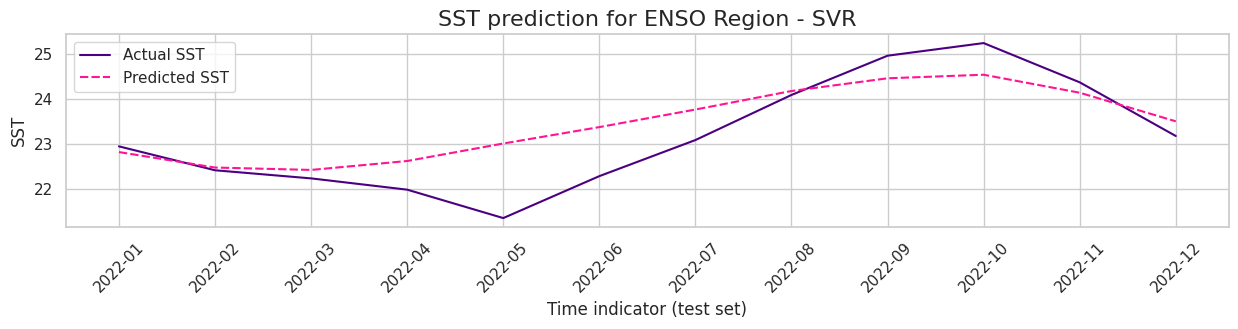

In [ ]:
indi_pipeline = DSPipeline(df, 20, -132, split_date, forecast_horizon=12)
print("RMSE: ", indi_pipeline.make_pipeline(1.0, 0.3))
print("MAPE: ", indi_pipeline.evaluate_mape())

indi_pipeline.plot_predict('ENSO Region - SVR', 'SVR')

### Mediterranean

           lat  lon       time  nbnds   sst  time_bnds
0         89.0  0.0 1981-12-01      0 -1.79 1981-12-01
2         89.0  0.0 1982-01-01      0 -1.79 1982-01-01
4         89.0  0.0 1982-02-01      0 -1.79 1982-02-01
6         89.0  0.0 1982-03-01      0 -1.79 1982-03-01
8         89.0  0.0 1982-04-01      0 -1.79 1982-04-01
...        ...  ...        ...    ...   ...        ...
64022390 -90.0 -1.0 2022-09-01      0 -1.79 2022-09-01
64022392 -90.0 -1.0 2022-10-01      0 -1.79 2022-10-01
64022394 -90.0 -1.0 2022-11-01      0 -1.79 2022-11-01
64022396 -90.0 -1.0 2022-12-01      0 -1.79 2022-12-01
64022398 -90.0 -1.0 2023-01-01      0 -1.79 2023-01-01

[32011200 rows x 6 columns]
Initializing
Lat: 36, Lon: 18
[16.609999  15.66      14.83      14.83      16.16      18.57
 23.17      25.56      26.47      25.71      23.89      20.43
 17.71      16.        14.96      14.839999  15.92      19.23
 21.56      24.96      26.099998  24.64      22.5       19.92
 17.09      15.62      14.889999 

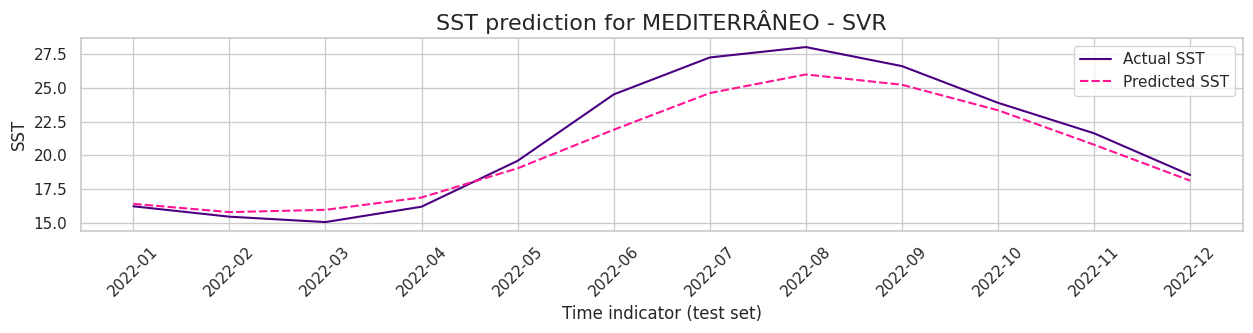

In [ ]:
indi_pipeline = DSPipeline(df, 36, 18, split_date, forecast_horizon=12)
print("RMSE: ", indi_pipeline.make_pipeline(1.0, 0.3))
print("MAPE: ", indi_pipeline.evaluate_mape())
indi_pipeline.plot_predict('MEDITERRÂNEO - SVR', 'SVR')

### Atlantic Ocean

RMSE:  0.5347251466778309
MAPE:  0.015623326656531758


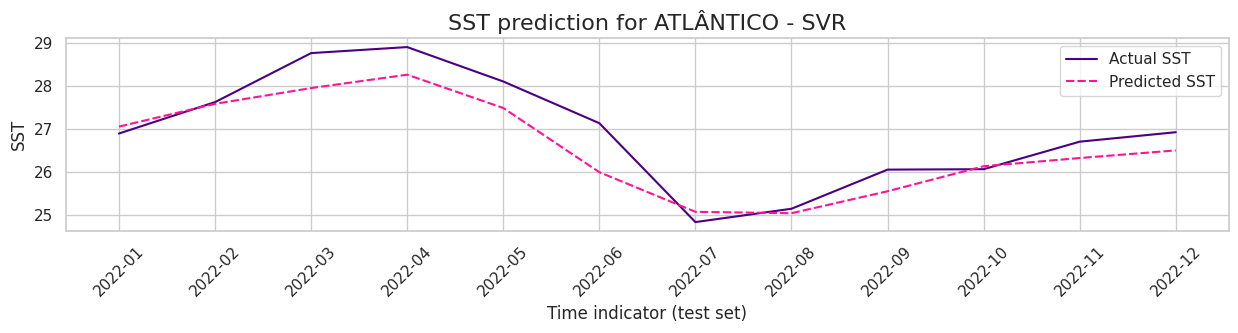

In [ ]:
indi_pipeline = DSPipeline(df, 0, -22, split_date, forecast_horizon=12)
print("RMSE: ", indi_pipeline.make_pipeline(1.0, 0.3))
print("MAPE: ", indi_pipeline.evaluate_mape())
indi_pipeline.plot_predict('ATLÂNTICO - SVR', 'SVR')

### Humboldt

Initializing
Lat: -22, Lon: -72
[0.63670594 0.62641585 0.73441344 ... 0.32512861 0.33221498 0.35176736]
[ 0.27341187  0.2528317   0.4688269  ... -0.34974277 -0.33557004
 -0.29646528]
Total length: 2038
1920 22
Train/test proportion: 0.9421000981354269/0.010794896957801767


100%|██████████| 1728/1728 [00:02<00:00, 594.46it/s]


Obtained 1728 subseries
RMSE:  0.5206175016250814
MAPE:  0.02494474973382749


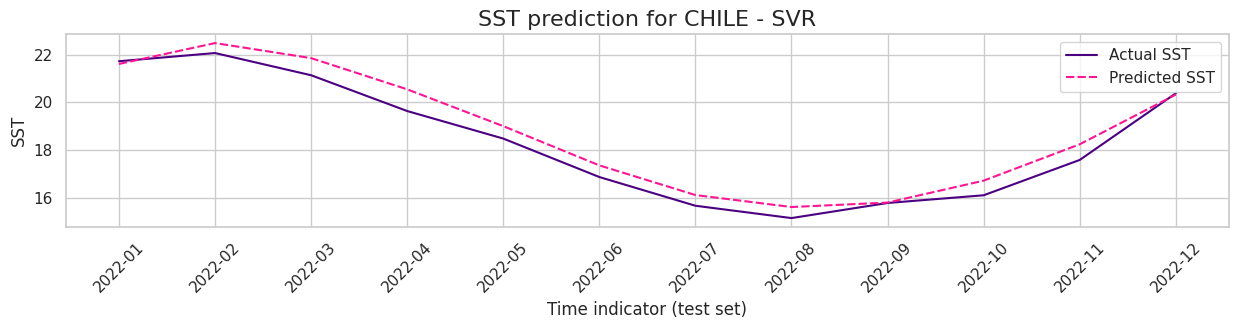

In [ ]:
indi_pipeline = DSPipeline(df, -22, -72, split_date, forecast_horizon=12)
print("RMSE: ", indi_pipeline.make_pipeline(1.0, 0.3))
print("MAPE: ", indi_pipeline.evaluate_mape())
indi_pipeline.plot_predict('CHILE - SVR', 'SVR')

In [ ]:
pipeline1 = DSPipeline(df, -56, 80, split_date, forecast_horizon=12)
print("RMSE: ", pipeline1.make_pipeline(1.0, 0.01))

pipeline2 = DSPipeline(df, 36, 18, split_date, forecast_horizon=12)
print("RMSE: ", pipeline2.make_pipeline(1.0, 0.01))

pipeline3 = DSPipeline(df, 0, -2, split_date, forecast_horizon=12)
print("RMSE: ", pipeline3.make_pipeline(1.0, 0.01))


Initializing
Lat: -56, Lon: 80
[0.67455363 0.79580027 0.80168074 ... 0.36432543 0.30134213 0.32530108]
[ 0.34910727  0.59160054  0.6033615  ... -0.27134913 -0.39731574
 -0.34939784]
Total length: 2038
1921 21
Train/test proportion: 0.9425907752698724/0.010304219823356232


  0%|          | 0/1729 [00:00<?, ?it/s]100%|██████████| 1729/1729 [00:04<00:00, 369.58it/s]


Obtained 1729 subseries
RMSE:  0.2374193772612375
Initializing
Lat: 36, Lon: 18
[0.22251053 0.19118312 0.1807629  ... 0.8891512  0.8264598  0.74953777]
[-0.55497897 -0.61763376 -0.6384742  ...  0.77830243  0.65291965
  0.49907553]
Total length: 2038
1921 21
Train/test proportion: 0.9425907752698724/0.010304219823356232


100%|██████████| 1729/1729 [00:04<00:00, 398.99it/s]


Obtained 1729 subseries
RMSE:  1.3170178034657616
Initializing
Lat: 0, Lon: -2
[0.52938354 0.5255629  0.75756633 ... 0.40840217 0.48857298 0.575799  ]
[ 0.05876708  0.05112576  0.51513267 ... -0.18319565 -0.02285403
  0.15159798]
Total length: 2038
1921 21
Train/test proportion: 0.9425907752698724/0.010304219823356232


100%|██████████| 1729/1729 [00:04<00:00, 374.05it/s]

Obtained 1729 subseries
RMSE:  0.38402854640960427


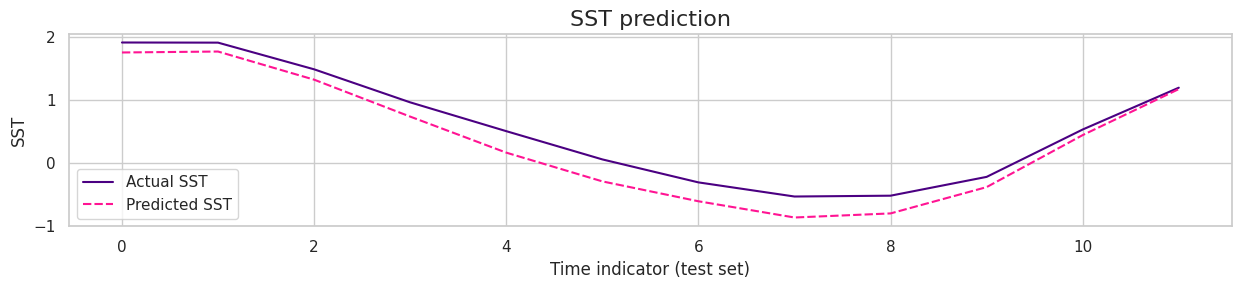

In [ ]:
pipeline1.plot_predict()

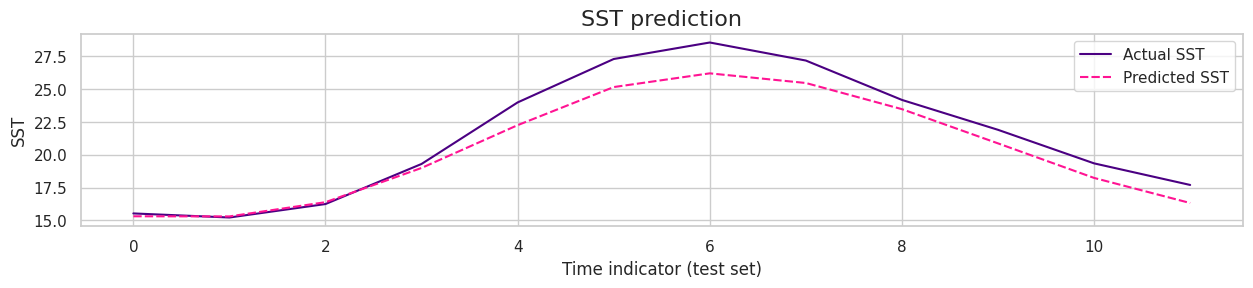

In [ ]:
pipeline2.plot_predict()

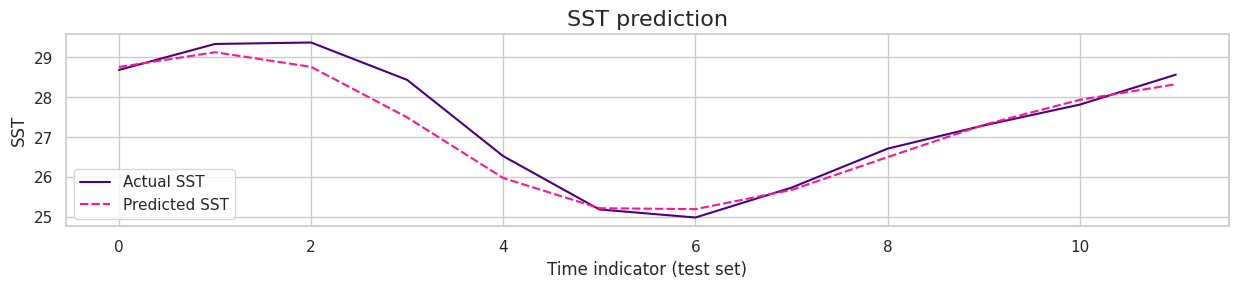

In [ ]:
pipeline3.plot_predict()

## Teste Expandido
Nessa seçao iremos expandir a quantidade de testes, executando o SARIMA para cerca de 100 séries temporais

#### Lendo os pontos pré-definidos

In [13]:
def read_list_points(filename):
    list_points = []
    with open(filename, 'r') as file:
        for line in file:
            line_split = line.split(',')
            try:
                list_points.append((int(line_split[1]), int(line_split[2])))
            except ValueError:
                pass
    return list_points

In [14]:
list_points = read_list_points('../dados/pontos.csv')

#### Rodando o SVR e calculando o erro

In [15]:
from netuno import DSPipeline

In [16]:
error_list = []

for point_coordinates in tqdm(list_points):
    try:
        point_pipeline = DSPipeline(df, point_coordinates[0], point_coordinates[1], split_date, forecast_horizon=12)
        rmse = point_pipeline.make_pipeline(.3, 0.3)
        mape = point_pipeline.evaluate_mape()
        error_list.append((rmse, mape))
    except Exception as e:
        print(f'{e} - lat: {point_coordinates[0]}; lon:{point_coordinates[1]}')


  0%|          | 0/100 [00:00<?, ?it/s]

  1%|          | 1/100 [00:00<00:27,  3.59it/s]

lat: -50; lon:84


  3%|▎         | 3/100 [00:00<00:22,  4.31it/s]

lat: 30; lon:174
lat: 88; lon:8


  4%|▍         | 4/100 [00:00<00:21,  4.43it/s]

lat: -66; lon:32


  5%|▌         | 5/100 [00:01<00:22,  4.22it/s]

lat: -68; lon:-20


  6%|▌         | 6/100 [00:01<00:27,  3.45it/s]

lat: 24; lon:-120


  7%|▋         | 7/100 [00:01<00:26,  3.55it/s]

lat: 44; lon:38


  8%|▊         | 8/100 [00:02<00:27,  3.37it/s]

lat: -46; lon:-136


  9%|▉         | 9/100 [00:02<00:29,  3.08it/s]

lat: -60; lon:-108


 10%|█         | 10/100 [00:03<00:33,  2.65it/s]

lat: -42; lon:-72


 11%|█         | 11/100 [00:03<00:37,  2.40it/s]

lat: 54; lon:-22


 12%|█▏        | 12/100 [00:03<00:35,  2.49it/s]

lat: 20; lon:-24


 13%|█▎        | 13/100 [00:04<00:34,  2.55it/s]

lat: -58; lon:-160


 14%|█▍        | 14/100 [00:04<00:31,  2.71it/s]

lat: -66; lon:-12


 15%|█▌        | 15/100 [00:04<00:30,  2.76it/s]

lat: -50; lon:134


 16%|█▌        | 16/100 [00:05<00:31,  2.68it/s]

lat: 80; lon:-4


 17%|█▋        | 17/100 [00:05<00:30,  2.69it/s]

lat: -16; lon:-36


 18%|█▊        | 18/100 [00:06<00:30,  2.67it/s]

lat: -66; lon:-110


 19%|█▉        | 19/100 [00:06<00:29,  2.76it/s]

lat: -8; lon:-22


 20%|██        | 20/100 [00:06<00:29,  2.74it/s]

lat: 40; lon:-10


 21%|██        | 21/100 [00:07<00:28,  2.77it/s]

lat: -50; lon:-120


 22%|██▏       | 22/100 [00:07<00:28,  2.72it/s]

lat: -74; lon:-142


 23%|██▎       | 23/100 [00:07<00:28,  2.69it/s]

lat: 72; lon:52


 24%|██▍       | 24/100 [00:08<00:28,  2.68it/s]

lat: -56; lon:22


 25%|██▌       | 25/100 [00:08<00:26,  2.80it/s]

lat: -36; lon:98


 26%|██▌       | 26/100 [00:08<00:26,  2.83it/s]

lat: 48; lon:-40


 27%|██▋       | 27/100 [00:09<00:25,  2.82it/s]

lat: 74; lon:-76


 28%|██▊       | 28/100 [00:09<00:25,  2.80it/s]

lat: -72; lon:-142


 29%|██▉       | 29/100 [00:10<00:24,  2.87it/s]

lat: 80; lon:74


 30%|███       | 30/100 [00:10<00:25,  2.80it/s]

lat: 4; lon:-156


 31%|███       | 31/100 [00:10<00:25,  2.73it/s]

lat: -54; lon:168


 32%|███▏      | 32/100 [00:11<00:24,  2.78it/s]

lat: -44; lon:44


 33%|███▎      | 33/100 [00:11<00:22,  2.96it/s]

lat: 34; lon:-174


 34%|███▍      | 34/100 [00:11<00:19,  3.32it/s]

lat: -58; lon:164


 35%|███▌      | 35/100 [00:11<00:18,  3.51it/s]

lat: -66; lon:4


 36%|███▌      | 36/100 [00:12<00:18,  3.45it/s]

lat: 52; lon:-132


 37%|███▋      | 37/100 [00:12<00:19,  3.23it/s]

lat: 52; lon:-4


 38%|███▊      | 38/100 [00:12<00:20,  3.09it/s]

lat: -50; lon:40


 39%|███▉      | 39/100 [00:13<00:19,  3.13it/s]

lat: -42; lon:126


 40%|████      | 40/100 [00:13<00:22,  2.71it/s]

lat: -52; lon:-86


 41%|████      | 41/100 [00:13<00:20,  2.88it/s]

lat: -10; lon:-16


 42%|████▏     | 42/100 [00:14<00:19,  2.99it/s]

lat: 28; lon:-142


 43%|████▎     | 43/100 [00:14<00:18,  3.03it/s]

lat: -70; lon:-28


 44%|████▍     | 44/100 [00:14<00:17,  3.25it/s]

lat: 36; lon:164


 45%|████▌     | 45/100 [00:15<00:16,  3.36it/s]

lat: -12; lon:60


 46%|████▌     | 46/100 [00:15<00:16,  3.25it/s]

lat: 30; lon:-26


 47%|████▋     | 47/100 [00:15<00:15,  3.37it/s]

lat: 86; lon:-162


 48%|████▊     | 48/100 [00:16<00:16,  3.19it/s]

lat: -46; lon:-64


 49%|████▉     | 49/100 [00:16<00:15,  3.31it/s]

lat: -26; lon:88


 50%|█████     | 50/100 [00:16<00:16,  3.03it/s]

lat: -60; lon:-54


 51%|█████     | 51/100 [00:17<00:14,  3.27it/s]

lat: -42; lon:174


 52%|█████▏    | 52/100 [00:17<00:14,  3.42it/s]

lat: 52; lon:144


 53%|█████▎    | 53/100 [00:17<00:13,  3.52it/s]

lat: 84; lon:-148


 54%|█████▍    | 54/100 [00:17<00:14,  3.28it/s]

lat: -26; lon:154


 55%|█████▌    | 55/100 [00:18<00:14,  3.16it/s]

lat: -56; lon:122


 56%|█████▌    | 56/100 [00:18<00:13,  3.21it/s]

lat: 6; lon:170


 57%|█████▋    | 57/100 [00:18<00:13,  3.29it/s]

lat: 28; lon:-156


 58%|█████▊    | 58/100 [00:19<00:11,  3.50it/s]

lat: -46; lon:-160


 59%|█████▉    | 59/100 [00:19<00:12,  3.38it/s]

lat: 42; lon:-38


 60%|██████    | 60/100 [00:19<00:12,  3.32it/s]

lat: -12; lon:46


 61%|██████    | 61/100 [00:20<00:11,  3.27it/s]

lat: 34; lon:-76


 62%|██████▏   | 62/100 [00:20<00:11,  3.39it/s]

lat: -52; lon:-82


 63%|██████▎   | 63/100 [00:20<00:12,  3.00it/s]

lat: -12; lon:110


 64%|██████▍   | 64/100 [00:20<00:10,  3.39it/s]

lat: -42; lon:-32


 65%|██████▌   | 65/100 [00:21<00:09,  3.61it/s]

lat: 50; lon:-4


 66%|██████▌   | 66/100 [00:21<00:08,  3.90it/s]

lat: 84; lon:92


 67%|██████▋   | 67/100 [00:21<00:08,  3.86it/s]

lat: 62; lon:-30


 68%|██████▊   | 68/100 [00:21<00:07,  4.10it/s]

lat: -64; lon:-8


 70%|███████   | 70/100 [00:22<00:06,  4.52it/s]

lat: 24; lon:68
lat: 66; lon:22


 71%|███████   | 71/100 [00:22<00:06,  4.64it/s]

lat: -14; lon:96


 72%|███████▏  | 72/100 [00:22<00:06,  4.57it/s]

lat: -64; lon:156


 73%|███████▎  | 73/100 [00:22<00:06,  4.39it/s]

lat: 58; lon:176


 74%|███████▍  | 74/100 [00:23<00:06,  4.08it/s]

lat: 60; lon:-56


 75%|███████▌  | 75/100 [00:23<00:06,  3.63it/s]

lat: 10; lon:-130


 76%|███████▌  | 76/100 [00:23<00:06,  3.54it/s]

lat: 16; lon:-16


 77%|███████▋  | 77/100 [00:24<00:06,  3.74it/s]

lat: 62; lon:-10


 78%|███████▊  | 78/100 [00:24<00:05,  3.76it/s]

lat: 74; lon:74


 79%|███████▉  | 79/100 [00:24<00:05,  3.69it/s]

lat: 24; lon:134


 80%|████████  | 80/100 [00:24<00:05,  3.71it/s]

lat: 28; lon:-24


 81%|████████  | 81/100 [00:25<00:04,  3.83it/s]

lat: 50; lon:-146


 82%|████████▏ | 82/100 [00:25<00:04,  3.84it/s]

lat: -42; lon:-92


 83%|████████▎ | 83/100 [00:25<00:04,  3.62it/s]

lat: 12; lon:-112


 84%|████████▍ | 84/100 [00:26<00:04,  3.45it/s]

lat: -34; lon:-152


 85%|████████▌ | 85/100 [00:26<00:04,  3.61it/s]

lat: 22; lon:-154


 86%|████████▌ | 86/100 [00:26<00:03,  3.73it/s]

lat: -62; lon:-150


 87%|████████▋ | 87/100 [00:26<00:03,  3.80it/s]

lat: 28; lon:152


 88%|████████▊ | 88/100 [00:27<00:03,  3.91it/s]

lat: -24; lon:4


 89%|████████▉ | 89/100 [00:27<00:02,  3.97it/s]

lat: -50; lon:-158


 90%|█████████ | 90/100 [00:27<00:02,  3.49it/s]

lat: 40; lon:-146


 91%|█████████ | 91/100 [00:28<00:02,  3.08it/s]

lat: 78; lon:146


 92%|█████████▏| 92/100 [00:28<00:02,  3.00it/s]

lat: 86; lon:-12


 93%|█████████▎| 93/100 [00:28<00:02,  2.83it/s]

lat: -34; lon:-50


 94%|█████████▍| 94/100 [00:29<00:02,  2.66it/s]

lat: 84; lon:18


 95%|█████████▌| 95/100 [00:29<00:01,  2.58it/s]

lat: -28; lon:2


 96%|█████████▌| 96/100 [00:29<00:01,  2.66it/s]

lat: -64; lon:46


 97%|█████████▋| 97/100 [00:30<00:01,  2.63it/s]

lat: -12; lon:-90


 98%|█████████▊| 98/100 [00:30<00:00,  2.53it/s]

lat: -2; lon:158


 99%|█████████▉| 99/100 [00:31<00:00,  2.43it/s]

lat: 34; lon:172


100%|██████████| 100/100 [00:31<00:00,  3.16it/s]

lat: 12; lon:50


In [70]:
results_df = pd.DataFrame(error_list)
results_df.rename({0: 'rmse', 1: 'mape'}, axis=1).to_csv('../dados/svr_results.csv')

## Sequential SVR

Standartize data

In [201]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [202]:
print(len(np.unique(df['sst'].to_numpy())))
print(np.count_nonzero(np.isnan(df['sst'].to_numpy())))

3690
0


In [203]:
df['sst'].to_numpy().reshape(-1, 1)

array([[-1.79],
       [-1.79],
       [-1.79],
       ...,
       [-1.79],
       [-1.79],
       [-1.79]], dtype=float32)

In [204]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(df['sst'].to_numpy().reshape(-1, 1)) 

MinMaxScaler()

In [205]:
new_sst = scaler.transform(df['sst'].to_numpy().reshape(-1, 1))

In [206]:
len(np.unique(new_sst))

3690

In [207]:
df['sst'] = new_sst

In [86]:
def read_list_points(filename):
    list_points = []
    with open(filename, 'r') as file:
        for line in file:
            line_split = line.split(',')
            try:
                list_points.append((int(line_split[1]), int(line_split[2])))
            except ValueError:
                pass
    return list_points

In [87]:
list_points = read_list_points('../dados/pontos.csv')

In [285]:
from sklearn.svm import SVR, NuSVR
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
import random

In [209]:
def exp_decay(x):
    return np.exp(-x)

In [339]:
regressor = DecisionTreeRegressor(
    max_depth=1,
)

class GradientBoosting:
    pipeline_list: list[DSPipeline]
    def __init__(self, original_point, list_points, horizon: int = 12, learning_rate: float = 0.1):
        self.pipeline_list = []
        self.predict_pipeline_list = []
        self.horizon = horizon
        self.learning_rate = learning_rate

        self.pipeline_list.append(
            DSPipeline(
                df, original_point[0], original_point[1], 
                split_date, forecast_horizon=1, regressor=DummyRegressor()
            )
        )

        list_points.insert(0, original_point)

        for point in list_points:
            pipeline = DSPipeline(
                df, point[0], point[1], split_date, forecast_horizon=1, 
                regressor=regressor
            )
            self.pipeline_list.append(pipeline)


        for pipeline in self.pipeline_list:
            pipeline.window = 24
            pipeline.subserie_dtw = SubserieDTW(
                pipeline.df, pipeline.lat, pipeline.lon, pipeline.split_date,
                window=pipeline.window, forecast_horizon=pipeline.forecast_horizon)

            pipeline.subserie_dtw.get_all_subseries()
        
        # self.pipeline_list = [y for x in self.pipeline_list for y in (x,)*10]
        # random.shuffle(self.pipeline_list)

    def fit(self):
        _, y_train = self.pipeline_list[0].subserie_dtw.get_train(1)
        rmse_error = 100
        residuals_at_iteration = []
        residuals = y_train
        it = 0
        y_true = self.get_y_true()

        print('FITTING')
        for pipeline in self.pipeline_list:
            self.predict_pipeline_list.append(pipeline)
            learning_rate = 1 if it == 0 else self.learning_rate
            x_train, _ = pipeline.subserie_dtw.get_train(1)
            pipeline.fit(x_train, residuals)
            y_train_predicted = pipeline.predict(x_train)


            # early stopping
            y_pred = self.predict()
            rmse_error = SSTHelper.rmse(y_true, y_pred)

            if it != 0 and (residuals_at_iteration[-1] - rmse_error) < 0:
                # self.predict_pipeline_list.pop()
                # gradient
                print('Weak tree')
                # break
            else:
                residuals += y_train_predicted * -1 * learning_rate
                residuals_at_iteration.append(rmse_error)
            it += 1
            
        print(f'mean of residuals: {residuals_at_iteration}')

    def predict(self):
        total_y_pred = []
        it = 0
        for pipeline in self.predict_pipeline_list:
            learning_rate = 1 if it == 0 else self.learning_rate

            x_test, _ = pipeline.subserie_dtw.get_test(self.horizon)
            x_test = x_test[0]

            for _ in range(self.horizon):
                y_pred = pipeline.predict(x_test.reshape(1, -1))
                x_test = np.append(x_test, y_pred[0])
                x_test = x_test[1:]

            y_pred = x_test[-self.horizon:]
            if it == 0:
                total_y_pred = y_pred
            else:
                total_y_pred += y_pred * learning_rate
            it += 1

        return total_y_pred

    def get_y_true(self):
        _, y_true = self.pipeline_list[0].subserie_dtw.get_test(self.horizon)
        return y_true

In [342]:
rmse_list = []
mape_list = []
for point in (list_points[:1]):
    gb = GradientBoosting(point, [p for p in list_points if p != point], 12, 0.01)
    gb.fit()
    y_pred = gb.predict()
    y_pred = scaler.inverse_transform([y_pred])
    y_true = gb.get_y_true()
    y_true = scaler.inverse_transform([y_true])
    rmse_list.append(SSTHelper.rmse(y_pred, y_true))
    mape_list.append(SSTHelper.mape(y_pred, y_true))

FITTING
Weak tree
Weak tree
Weak tree
Weak tree
Weak tree
Weak tree
Weak tree
Weak tree
Weak tree
Weak tree
Weak tree
Weak tree
Weak tree
Weak tree
Weak tree
Weak tree
Weak tree
Weak tree
Weak tree
Weak tree
Weak tree
Weak tree
Weak tree
Weak tree
Weak tree
Weak tree
Weak tree
Weak tree
Weak tree
Weak tree
Weak tree
Weak tree
Weak tree
Weak tree
Weak tree
Weak tree
Weak tree
Weak tree
Weak tree
Weak tree
Weak tree
Weak tree
Weak tree
Weak tree
Weak tree
Weak tree
Weak tree
Weak tree
Weak tree
Weak tree
Weak tree
Weak tree
Weak tree
Weak tree
Weak tree
Weak tree
Weak tree
Weak tree
Weak tree
Weak tree
Weak tree
Weak tree
Weak tree
Weak tree
Weak tree
Weak tree
Weak tree
Weak tree
Weak tree
Weak tree
Weak tree
Weak tree
Weak tree
Weak tree
Weak tree
Weak tree
Weak tree
Weak tree
Weak tree
Weak tree
Weak tree
Weak tree
Weak tree
mean of residuals: [0.03615683807174643, 0.03602300532099751, 0.03589133979326797, 0.03576180845829594, 0.03563439048586355, 0.035518544430157145, 0.0353951992963

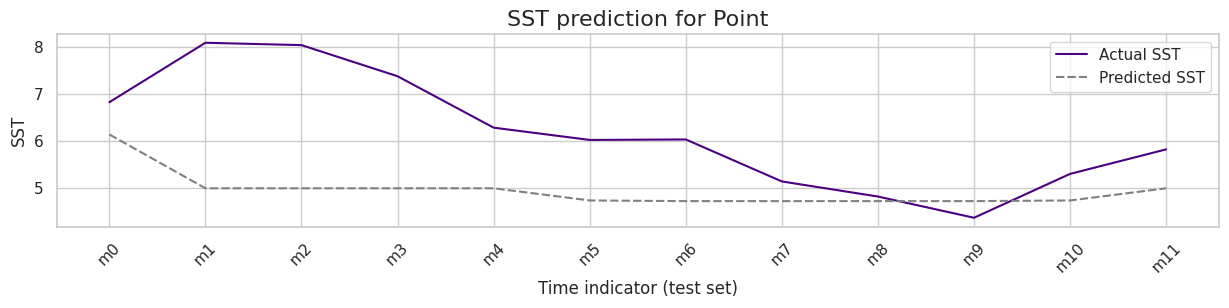

0.2570626057795599
1.6111199649245422


In [343]:
SSTHelper.default_plot(y_true[0], y_pred[0], 'Point', 'Sequential')
print(SSTHelper.mape(y_pred, y_true))
print(SSTHelper.rmse(y_pred, y_true))

In [321]:
results_df = pd.DataFrame([rmse_list, mape_list]).T
results_df.rename({0: 'rmse', 1: 'mape'}, axis=1).to_csv('../dados/boosting_results.csv')

In [322]:
results_df

,0,1
0,0.641591,0.086723
1,1.323831,0.049598
2,0.000000,0.000000
3,0.340995,0.812411
4,0.177373,0.245675
...,...,...
95,0.258522,0.273140
96,0.909117,0.035976
97,0.255392,0.007085
98,1.485365,0.065057


In [ ]:
pipeline_list = []
residuals = []

for point in list_points[:5]:
    pipeline = DSPipeline(df, point[0], point[1], split_date, forecast_horizon=1)
    pipeline.window = 24
    pipeline.subserie_dtw = SubserieDTW(
        pipeline.df, pipeline.lat, pipeline.lon, pipeline.split_date,
        window=pipeline.window, forecast_horizon=pipeline.forecast_horizon)

    pipeline.subserie_dtw.get_all_subseries()
    pipeline.x_train, pipeline.y_train = pipeline.subserie_dtw.get_train(1)
    pipeline.fit()
    residuals.append(pipeline.predict(pipeline.x_train))

    print(np.mean(residuals[-1]))

5.578203140704556
22.28029224291492
-1.7899999618530273
-0.842534006420793
-1.2362103271510374


[24.35000038 23.6099987  22.04999924 19.65999985 18.60000038 17.10000038
 16.63999939 16.43000031 16.60000038 18.29999924 20.69999886 22.6099987
 23.18999863 23.20999908 21.40999985 19.80999947 17.77999878 16.63999939
 15.71999931 15.27999973 16.55999947 18.10000038 20.37999916 22.37661327]
[23.6099987  22.04999924 19.65999985 18.60000038 17.10000038 16.63999939
 16.43000031 16.60000038 18.29999924 20.69999886 22.6099987  23.18999863
 23.20999908 21.40999985 19.80999947 17.77999878 16.63999939 15.71999931
 15.27999973 16.55999947 18.10000038 20.37999916 22.37661327 23.53963256]
[22.04999924 19.65999985 18.60000038 17.10000038 16.63999939 16.43000031
 16.60000038 18.29999924 20.69999886 22.6099987  23.18999863 23.20999908
 21.40999985 19.80999947 17.77999878 16.63999939 15.71999931 15.27999973
 16.55999947 18.10000038 20.37999916 22.37661327 23.53963256 22.94979503]
[19.65999985 18.60000038 17.10000038 16.63999939 16.43000031 16.60000038
 18.29999924 20.69999886 22.6099987  23.18999863 

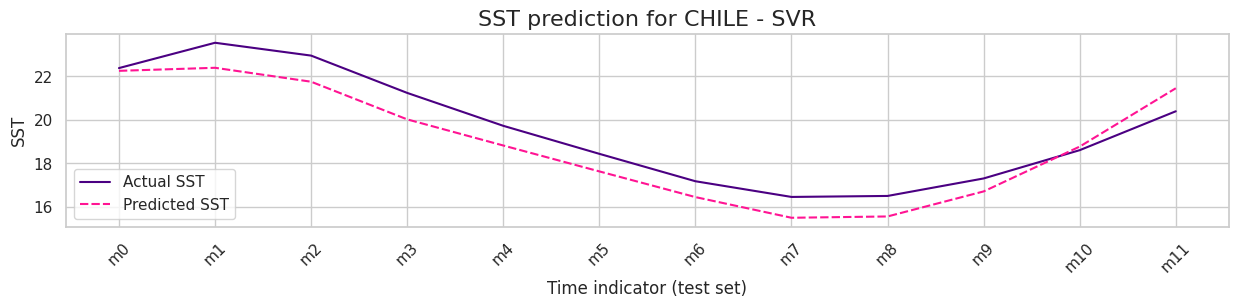

In [ ]:
horizon = 12
indi_pipeline = DSPipeline(df, -22, -72, split_date, forecast_horizon=1)
residuals = indi_pipeline.make_pipeline(1, 1.0)
_, y_true = indi_pipeline.subserie_dtw.get_test(horizon)
x_test = indi_pipeline.x_test[0].reshape(1, -1)

for i in range(horizon):
    y_pred = indi_pipeline.predict(x_test.reshape(1, -1))
    x_test = np.append(x_test, y_pred[0])
    x_test = x_test[1:]
    print(x_test)
    

y_pred = x_test[-horizon:]
SSTHelper.default_plot(y_pred, y_true, 'CHILE - SVR', 'SVR')
